In [131]:
# %pip install databricks-langchain 
# %pip install langchain-community pymupdf 
# %pip install langchain-pinecone pinecone 
# %pip install langchain-ollama 

In [132]:
import os
pdfs = []
for root, dirs, files in os.walk("rag-dataset"):
    for file in files:
        if file.endswith(".pdf"):
            pdfs.append(os.path.join(root, file))
pdfs

['rag-dataset/finance/amazon/amazon-10-q-q3-2024.pdf',
 'rag-dataset/finance/google/goog-10-q-q3-2024.pdf',
 'rag-dataset/finance/facebook/Meta-09-30-2024-Exhibit-99-1_FINAL.pdf',
 'rag-dataset/finance/facebook/META-Q3-2024-Follow-Up-Call-Transcript.pdf',
 'rag-dataset/finance/facebook/Earnings-Presentation-Q3-2024.pdf',
 'rag-dataset/finance/facebook/META-Q3-2024-Earnings-Call-Transcript.pdf',
 'rag-dataset/health supplements/1. dietary supplements - for whom.pdf',
 'rag-dataset/health supplements/3.health_supplements_side_effects.pdf',
 'rag-dataset/health supplements/2. Nutraceuticals research.pdf',
 'rag-dataset/gym supplements/2. High Prevalence of Supplement Intake.pdf',
 'rag-dataset/gym supplements/1. Analysis of Actual Fitness Supplement.pdf']

In [ ]:
from dotenv import load_dotenv
from langchain.document_loaders import PyMuPDFLoader 
from langchain.text_splitter import RecursiveCharacterTextSplitter 

load_dotenv() 
health_supplements_pdfs = pdfs[6:9]
texts = []
for pdf in health_supplements_pdfs:
    loader = PyMuPDFLoader(pdf)
    pages = loader.load()
    texts.extend(pages) 

print(len(texts)) 

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.split_documents(texts)

print(len(docs))


In [134]:
import os
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from pinecone import ServerlessSpec
from initializeLLM import get_ollama_embedding

pinecone_index_name = os.getenv("PINECONE_INDEX_NAME")
pinecone_api_key = os.getenv("PINECONE_API_KEY")

embeddings = get_ollama_embedding()

pc = Pinecone(api_key=pinecone_api_key)

if not pc.has_index(pinecone_index_name):
    pc.create_index(
        name=pinecone_index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
index = pc.Index(pinecone_index_name)
vector_store = PineconeVectorStore(embedding=embeddings, index=index) 
# vector_store.add_documents(docs)

[0.015993515, -0.00062255946, -0.15882872, -0.012685137, -0.01772414, 0.061347138, -0.0054875617, -0.0106531, -0.0055957567, -0.0407723, 0.013800241, 0.07319869, 0.01947844, 0.05118199, 0.026937848, -0.05958253, 0.007579741, -0.062437803, -0.029513499, 0.02528373, -0.03170574, -0.089156374, 0.008608357, 0.01985421, 0.12295306, 0.009044305, -0.037427314, 0.07181586, 0.012586577, -0.0032036244, -0.0051400512, 0.007734456, -0.0016507168, 0.034074236, 0.056595176, 0.00039103726, 0.022019977, 0.007560744, 0.024588065, -0.026115306, 0.012698323, -0.0006432549, 0.012741588, 0.0057689203, 0.07582881, -0.017261123, -0.019303396, -0.03416783, 0.06996755, -0.035534225, -0.046174865, -0.007327933, -0.0038501793, 0.055153757, 0.04707869, 0.016620874, 0.053463444, -0.035655934, 0.018318871, 0.055533573, 0.041765507, 0.05430297, 0.028150182, 0.03240944, 0.00077659986, -0.04753271, -0.014110568, 0.073531404, 0.023689367, 0.009196028, 0.08969711, 0.0011509941, 0.026200863, 0.026710622, 0.03178185, 0.02

Retrivere

In [136]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs = {'k': 5})
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "health_supplements",
    "Search and retrun information about the Health Supplements for workout and gym",
)
tools = [retriever_tool]
tools

[Tool(name='health_supplements', description='Search and retrun information about the Health Supplements for workout and gym', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x123f7aa60>, retriever=VectorStoreRetriever(tags=['PineconeVectorStore', 'OllamaEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x122f3e850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x124028ee0>, retriever=VectorStoreRetriever(tags=['PineconeVectorStore', 'OllamaEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x122f3e850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_typ

In [137]:
from typing import Annotated, Sequence, TypedDict, Literal 
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [138]:
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from initializeLLM import get_ollama_llm

In [151]:
llm = get_ollama_llm()

In [153]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm_with_structured_output = llm.with_structured_output(grade)
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    chain = prompt | llm_with_structured_output
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    if score == "yes":
        return "generate"
    else:
        return "rewrite"

In [160]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    messages = state["messages"]
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [155]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    response = llm.invoke(msg)
    return {"messages": [response]}

In [156]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": format_docs(docs), "question": question})
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)
graph_builder.add_node("agent", agent)
retriever = ToolNode([retriever_tool])
graph_builder.add_node("retriever", retriever)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges( 
    "agent",
    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)
graph_builder.add_conditional_edges(
    "retriever",
    grade_documents
)
graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

graph = graph_builder.compile()

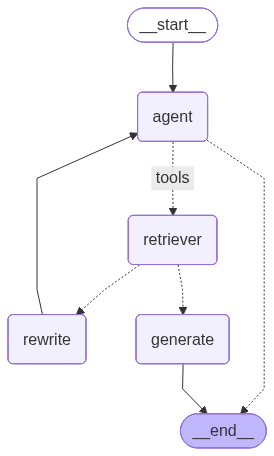

In [158]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [161]:
from pprint import pprint
query = {"messages": [HumanMessage("How gym supplements can help in muscle gain?")]}
for output in graph.stream(query):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

"Output from node 'agent':"
'----'
{   'messages': [   AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-09-13T03:41:46.869311Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3130853125, 'load_duration': 125754000, 'prompt_eval_count': 176, 'prompt_eval_duration': 1485048250, 'eval_count': 23, 'eval_duration': 1515686167, 'model_name': 'llama3.2:latest'}, id='run--5167ce3f-ad5f-4f49-a106-5ddc23cf4580-0', tool_calls=[{'name': 'health_supplements', 'args': {'query': 'gym supplements for muscle gain'}, 'id': '17969455-952d-48f9-ae9f-9b3677a43db9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 23, 'total_tokens': 199})]}
'\n------\n'
"Output from node 'retriever':"
'----'
{   'messages': [   ToolMessage(content='intended to burn fat and increase performance, muscle mass or strength. As examples, 53% \nof active-duty US Army soldiers report using at least one dietary supplement per week (60